# Topic Modeling

This notebook shows a simple task of topic modeling using a dataset of scientific papers retrieved from the Scopus website (https://www.scopus.com/). The data is in JSON format and it consists of titles, abstracts and links to different publications regarding NLP and text mining.

In [182]:
import json
import re
import random
import mpld3
import nltk
import pandas as pd
import numpy as np
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from scipy.cluster.hierarchy import ward, dendrogram
import matplotlib.pyplot as plt

We start by reading our data into memory.

In [200]:
with open("scientific_papers_data.json", "r") as read_file:
    data = json.load(read_file)

print(len(data["data"]))

1693


Here we can see an example of how our data is organized. It consists, for now, of 1693 entries of javascript objects containing 3 key-value pairs with the following keys: abstract, title and url.

## Processing the JSON file

Next, our main objective is to transform this JSON data into data structures more fitted to the application of our clustering algorithms.
We start by creating a list of all the papers' titles:

In [184]:
titles_list = []
for paper in data["data"]:
    title_words = paper["title"].split()
    title = []
    for word in title_words[1:]:
        title.append(word)
    titles_list.append(' '.join(title))

print("Number of items on the list {}".format(len(titles_list)))    
titles_list[:10]

Number of items on the list 1693


['Dynamic semantic textual document clustering using frequent terms and named entity',
 'Text clustering using statistical and semantic data',
 'Text clustering using semantic features for utilizing NFC access information',
 'Classification analysis of authorship fiction texts in the space of semantic fields',
 'Enhanced cross-domain document clustering with a semantically enhanced text stemmer (SETS)',
 'Uyghur text clustering based on semantic word set',
 'Size (and domain) matters: Evaluating semantic word space representations for biomedical text',
 'Text mining for wellbeing: Selecting stories using semantic and pragmatic features',
 'Refined semantic kernel matching pursuit for fast text classification',
 'Exploiting Turkish Wikipedia as a semantic resource for text classification']

We can see here the 10 first titles extracted from the JSON file as an example. Every paper title in the dataset starts with a number, so we processed it here to get rid of that information that won't be of any use for our analysis. Furthermore, we still have 1693 items, keeping it consistent with the previous counting for the whole document. Now, we'll do the same with the abstracts:

In [185]:
abstracts_list = []
for paper in data["data"]:
    abstracts_list.append(paper["abstract"])

print("Number of items on the list {}".format(len(abstracts_list)))    

Number of items on the list 1693


Here, once more, we have our data extracted from the JSON and represented as a list. Now our data is ready!

## Demonstration of tokenization and stemming

Here we will see how to further preprocess our data applying tokenization and stemming to all the words in both the titles and the abstracts lists. It can give us an idea of how this process is done when we apply the sklearn TF-IDF algortihm later on. 

In [186]:
def tokenize_and_stem(text):
    stemmer = SnowballStemmer("english")
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens



totalvocab_stemmed = []
totalvocab_tokenized = []

print("Tokenizing and stemming words form the titles...")
for title in titles_list:
    allwords_stemmed = tokenize_and_stem(title)  
    totalvocab_stemmed.extend(allwords_stemmed)  

    allwords_tokenized = tokenize_only(title)
    totalvocab_tokenized.extend(allwords_tokenized)

print("Tokenizing and stemming words from the abstracts...")
for abstract in abstracts_list:
    allwords_stemmed = tokenize_and_stem(abstract)  
    totalvocab_stemmed.extend(allwords_stemmed)  

    allwords_tokenized = tokenize_only(abstract)
    totalvocab_tokenized.extend(allwords_tokenized)

vocab_df = pd.DataFrame({'words': totalvocab_tokenized}, index=totalvocab_stemmed)
print("DONE!\n")

print("Shape of the dataframe: {}".format(vocab_df.shape))
vocab_df.head()

Tokenizing and stemming words form the titles...
Tokenizing and stemming words from the abstracts...
DONE!

Shape of the dataframe: (256345, 1)


,words
dynam,dynamic
semant,semantic
textual,textual
document,document
cluster,clustering


Here we have created a vocabulary dataframe consisting of all the words in both the titles and abstracts side by side with their stemmed counterparts. This dataframe could be used for further experiments, but in the next step we will see that the TfidfVectorizer class provided by the sklearn library will do all this work for us.

## TF-IDF matrix

So now, our next step will be to create the TF-IDF matrix using the class TfidfVectorizer provided by the sklearn library. We set some parameters regarding the maximum and minimum document frequency each n-gram must present to be added to our matrix, as well as the maximum number of features we want, the language so the algorithm can get rid of the stopwords for us, the tokenizer method we wish to use and the maximum size of the n-grams we want to consider (I set it to 4 in this example). 

In [187]:
print("Creating TF-IDF matrix...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.75, max_features=1000,
                                   min_df=0.15, stop_words='english',
                                   use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1, 4))
tfidf_matrix = tfidf_vectorizer.fit_transform(abstracts_list)
terms = tfidf_vectorizer.get_feature_names()
distances = 1 - cosine_similarity(tfidf_matrix)
print("TF-IDF matrix created. The matrix dimensions are: {}".format(tfidf_matrix.shape))

Creating TF-IDF matrix...
TF-IDF matrix created. The matrix dimensions are: (1693, 68)


So let's understand what we just did. An instance of the TfidfVectorizer class was created, to which we passed a couple parameters. Following that, we created a TF-IDF matrix using only the words obtained from the abstracts in our initial dataset. Because of the parameters we passed into the vectorizer object, we ended up with a sparse matrix of the shape 1693 items (different papers in this case) vs 68 n-grams (our features). Each entry in the intersection of a paper and a n-gram represents the tf-idf score calculated for the term in the respective document.    

We can take a look into the n-grams using the 'terms' variable created specifically with the purpose of storing this data:

In [188]:
print("Number of n-grams on the TF-IDF matrix: {}".format(len(terms)))
print("First 10 n-grams: {}".format(terms[:10]))

Number of n-grams on the TF-IDF matrix: 68
First 10 n-grams: ['algorithm', 'analysi', 'appli', 'applic', 'approach', 'automat', 'base', 'classif', 'classifi', 'cluster']


Furthermore, we calculated the cosine distance between all the documents, obtaining a 1693x1693 matrix, which was stored in the 'distances' variable.

In [189]:
print("Shape of the cosine distances matrix: {}".format(distances.shape))

Shape of the cosine distances matrix: (1693, 1693)


With this data at our disposal we are now able to use a clustering algorithm to identify the closest related papers we have in our dataset.

# K-means clustering

One of the main drawbacks of the k-means clustering algorithm is that we must provide a number of clusters to it in advance, as a parameter. To find out which number of clusters should be fed to the algorithm, a couple of methods have been devised. Below, we ilustrate one, the so called elbow (or knee) method.

This method consists in calculating the inertia (or wcss - within cluster sum of squares) metric for the k-means algorithm fitted to the data providing the algorithm wuth a bigger number of clusters at a time. A graph is then plotted to show the relationship between the wcss and the number of clusters chosen. To find the "optimal" number of clusters to the given data, one should choose a number of clusters so that adding another one doesn't give much better modeling of the data. That's represented by an angle in the graph, making it easier to spot the number where the marginal gain starts to drop.

Calculating KMeans with 1 clusters...
Calculating KMeans with 11 clusters...
Calculating KMeans with 21 clusters...
Calculating KMeans with 31 clusters...
Calculating KMeans with 41 clusters...
Calculating KMeans with 51 clusters...
Calculating KMeans with 61 clusters...
Calculating KMeans with 71 clusters...
Calculating KMeans with 81 clusters...
Calculating KMeans with 91 clusters...
Calculating KMeans with 101 clusters...
Calculating KMeans with 111 clusters...
Calculating KMeans with 121 clusters...
Calculating KMeans with 131 clusters...
Calculating KMeans with 141 clusters...
Calculating KMeans with 151 clusters...
Calculating KMeans with 161 clusters...
Calculating KMeans with 171 clusters...
Calculating KMeans with 181 clusters...
Calculating KMeans with 191 clusters...


/home/thomas/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


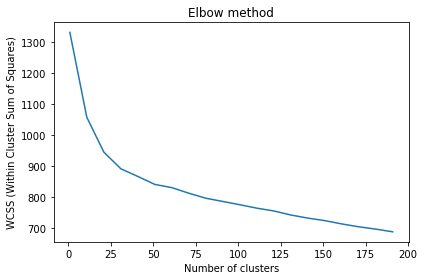

In [190]:
wcss = []
for i in range(0, 200, 10):
    print("Calculating KMeans with {} clusters...".format(i+1))
    kmeans = KMeans(n_clusters = i+1)
    kmeans.fit(tfidf_matrix)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 201, 10), wcss)
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS (Within Cluster Sum of Squares)')
plt.show()

So in the graph above we conclude that the elbow starts around n=25. So that's the value we will use to feed the algorithm and analyze our results:

In [191]:
num_clusters = 25
km = KMeans(n_clusters=num_clusters)

km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

papers = {'title': titles_list, 'abstract': abstracts_list, 'cluster': clusters}
papers_df = pd.DataFrame(papers, index=[clusters], columns=['title', 'abstract', 'cluster'])

papers_df.head()

,title,abstract,cluster
2,Dynamic semantic textual document clustering u...,Data is mostly stored in digital format rather...,2
2,Text clustering using statistical and semantic...,The explosive growth of information stored in ...,2
2,Text clustering using semantic features for ut...,This paper proposes a text clustering method u...,2
13,Classification analysis of authorship fiction ...,The use of naive Bayesian classifier (NB) and ...,13
2,Enhanced cross-domain document clustering with...,The aim of document clustering is to produce c...,2


Here we have created a dataframe consisting of all the papers titles related to its abstract and its cluster affiliation.

Now, we want to use the results from our K-Means fit to identify the words that are the most representative of each of the clusters. We'll show the 3 n-grams that are the closest to the centroid of each cluster. We do that in the cell below:

In [192]:
n_cluster_defining_words = 3

order_centroids = km.cluster_centers_.argsort()[:, ::-1]

terms_per_cluster = []
for i in range(num_clusters):
    list_of_terms = []
    for centroid in order_centroids[i, :n_cluster_defining_words]:        
        list_of_terms.append(terms[centroid])
    
    terms_per_cluster.append(list_of_terms)

Let's evaluate our results for the first cluster:
- Remember that the terms present in the titles weren't used to create the TF-IDF matrix, so there might be that the titles of the papers per se are not strongly correlated to each other, however their content (given the abstract) might be similar. 

In [193]:
print("Most representative terms for the first cluster: {}".format(terms_per_cluster[0]))
print("\nTitles of the papers in the first cluster:")
papers_df.loc[0]['title'].values.tolist()

Most representative terms for the first cluster: ['learn', 'differ', 'use']

Titles of the papers in the first cluster:


['Neural network agents for learning semantic text classification',
 'A supervised learning approach for automatic keyphrase extraction',
 'Learning to rank categories for web queries',
 'Learning semantic content-based profiles for cross-language recommendations',
 'Topic-weak-correlated latent dirichlet allocation',
 'Chinese question classification using multilevel random walk',
 'Not all seeds are equal: Measuring the quality of text mining seeds',
 'OpinionIt: A text mining system for cross-lingual opinion analysis',
 'Latent semantic analysis and keyword extraction for phishing classification',
 'Individual differences in the interpretation of text: Implications for information science',
 'Use of semantic principles in a collaborative system in order to support effective information retrieval',
 'A Semantic Scattering model for the automatic interpretation of English genitives',
 'Enhancing learning objects with an ontology-based memory',
 'Mining Chinese comparative sentences by

## MDS and K-Means visualization

Is there a better way to visualize this data, though, instead of just printing the representative terms versus the papers' titles related to each cluster? We can try creating a plot to demonstrate the distribution of the clusters, however we will have to do some work with our data to reduce the dimensionality.
- At the moment, we have 1693 papers divided in 25 clusters that spans 65 dimensions (number of features or n-grams in our TF-IDF matrix;
- Our goal is to reduce these 65 dimensions to 2, so we can visualize the data in a 2d plot;
- For this task, we'll apply the MDS (multidimensional scaling) technique

In [195]:
print("Performing the dimensionality reduction (MultiDimensional Scaling)...")
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
position = mds.fit_transform(distances)
xs, ys = position[:, 0], position[:, 1]

mds_df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles_list))
groups = mds_df.groupby('label')
print("DONE!")

Performing the dimensionality reduction (MultiDimensional Scaling)...
DONE!


Now we can visualize the results in a 2d plot:
- The plot is interactive. There's a toolbar in the bottom left that allows you to zoom in and move around.

In [196]:
cluster_colors = dict()
cluster_names = dict()
for cluster in range(num_clusters):
    color = "%06x" % random.randint(0, 0xFFFFFF)
    hex_number ='#'+ color
    cluster_colors[cluster] = hex_number    
    cluster_names[cluster] = terms_per_cluster[cluster]

print("Plotting...")
plt.rcParams.update({'figure.autolayout': True})
fig, ax = plt.subplots(figsize=(12, 8))
ax.margins(0.01)

for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18,
                     label=cluster_names[name], mec='none',
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]

    tooltip = mpld3.plugins.PointLabelTooltip(points[0], labels,
                                             voffset=10, hoffset=10)
    mpld3.plugins.connect(fig, tooltip)
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
ax.legend(bbox_to_anchor=(0., 0.02, 1., 1.), loc='lower right',
           ncol=3, mode="expand", borderaxespad=0., numpoints=1, fontsize=10)

mpld3.display(fig)

Plotting...


## Hierarchical Clustering - Ward algorithm and dendogram

The data seems a little messy in the 2d plot? Maybe because we tried to show 25 different clusters at once in 2d when, in reality, the distance between different points make much more sense in the original 65 dimensions. How about using another approach to try to understand the relations between the papers in our dataset?
- Now we'll try a hierarchical clustering alorithm (Ward) and plot a dendogram of the results:

Calculating the hierarchical clustering and plotting the dendogram...


/home/thomas/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


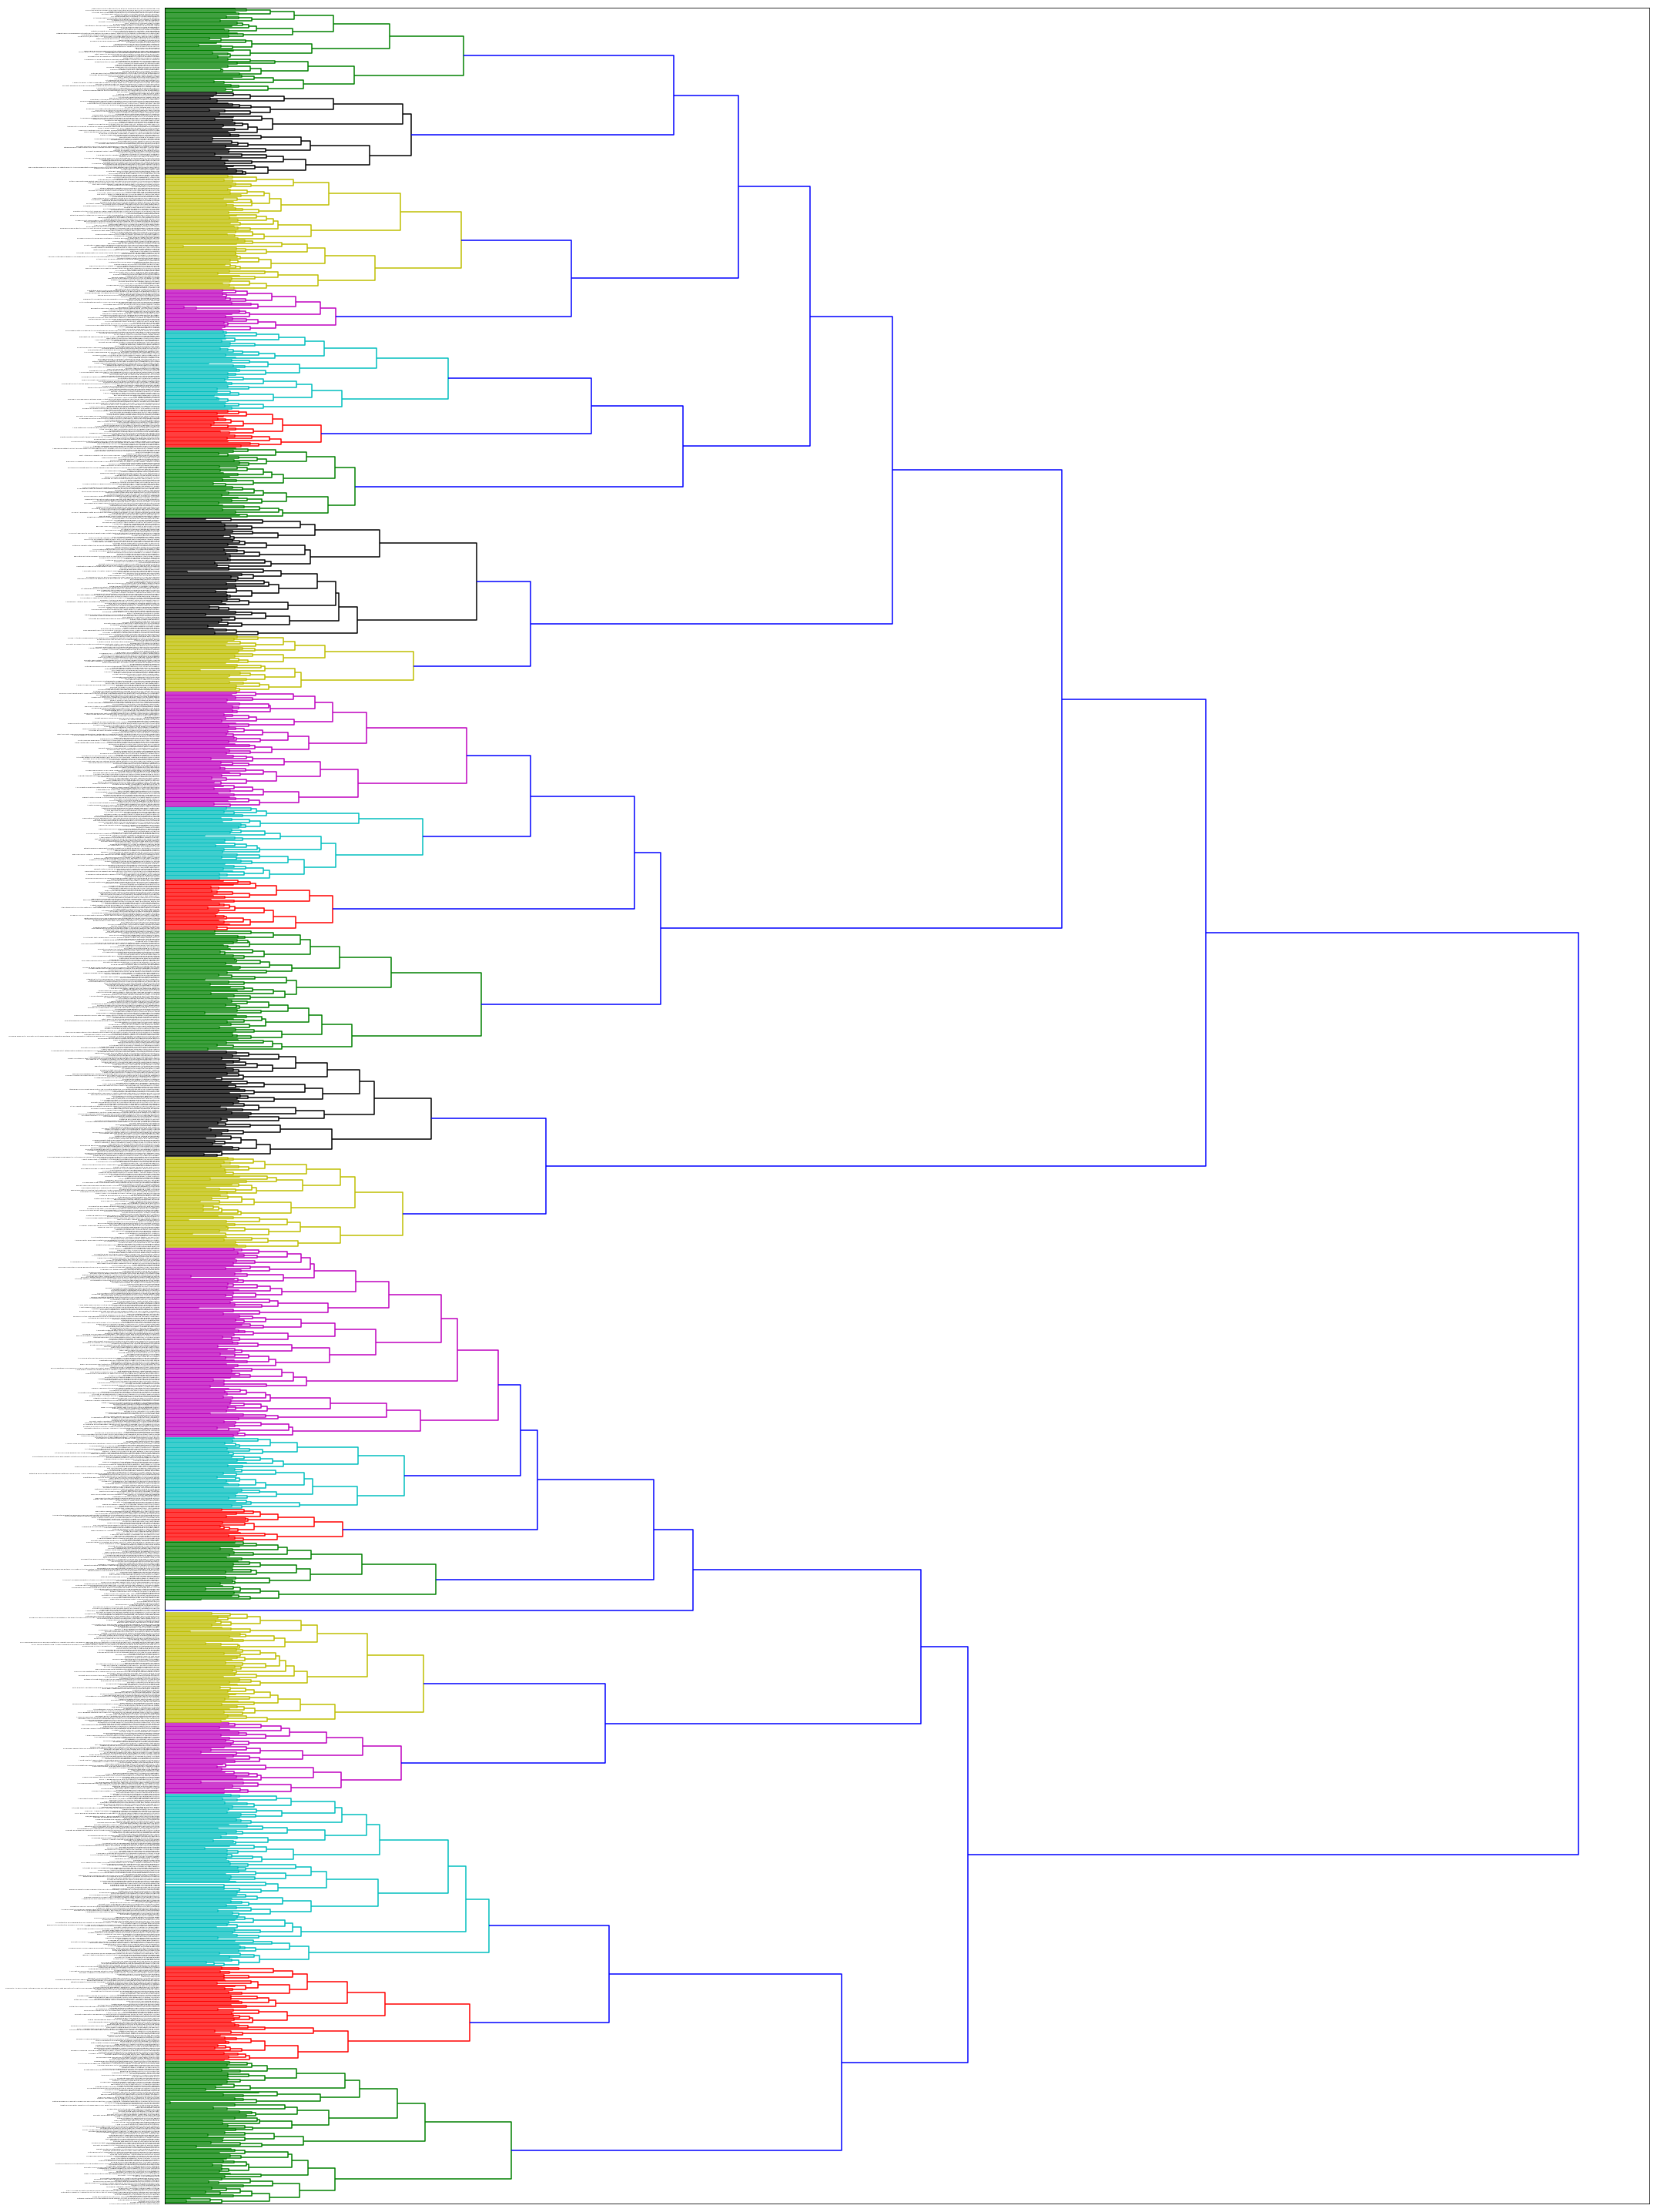

In [197]:
print("Calculating the hierarchical clustering and plotting the dendogram...")
linkage_matrix = ward(distances)
fig, ax = plt.subplots(figsize=(30, 40))
ax = dendrogram(linkage_matrix, orientation="right", labels=titles_list, leaf_font_size=2, color_threshold=21);

plt.rcParams.update({'figure.autolayout': True})

plt.tick_params( \
    axis='x',
    which='both',
    bottom='off',
    top='off',
    labelbottom='off')

plt.show()

- Since it might be difficult to analyze the figure in detail, a copy of it was provided in .png format. 

So, by tweaking the "color_threshold" parameter of the dendogram method, we were able to generate 25 clusters in this visualization as well. The advantage of this dendogram is that we can try many different vertical cuts to generate exactly the number of clusters we want

To evaluate our clustering algorithm, let's analyze the papers with the minimum distance between them (which is not 0), looking at their titles and abstracts in sequence:

In [199]:
initial_clusters = linkage_matrix[linkage_matrix[:,3] < 3]
initial_clusters = initial_clusters[initial_clusters[:,2] > 0]

print("Paper 1 title: {}".format(titles_list[initial_clusters[1][0].astype(np.int64)]))
print("Paper 1 abstract: {}".format(abstracts_list[initial_clusters[1][0].astype(np.int64)]))
print("\n\n")
print("Paper 2 title: {}".format(titles_list[initial_clusters[1][1].astype(np.int64)]))
print("Paper 2 abstract: {}".format(abstracts_list[initial_clusters[1][1].astype(np.int64)]))

Paper 1 title: A Novel Semantic Smoothing Method Based on Higher Order Paths for Text Classification
Paper 1 abstract: It has been shown that Latent Semantic Indexing (LSI) takes advantage of implicit higher-order (or latent) structure in the association of terms and documents. Higher order relations in LSI capture latent semantics. Inspired by this, a novel Bayesian framework for classification named Higher Order Naive Bayes (HONB), which can explicitly make use of these higher-order relations, has been introduced previously. We present a novel semantic smoothing method named Higher Order Smoothing (HOS) for the Naive Bayes algorithm. HOS is built on a similar graph based data representation of HONB which allows semantics in higher order paths to be exploited. Additionally, we take the concept one step further in HOS and exploited the relationships between instances of different classes in order to improve the parameter estimation when dealing with insufficient labeled data. As a resu

So, it seems like our clustering algorithm was able to relate two papers of the same research group, maybe even from the same author, since the similarities between the abstracts are blatant! Good job!